In [1]:
# Instala librerías necesarias
!pip install torch



[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

## - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2, 10, 10, 10, 10, 1] utilizando muestreos aleatorios de los puntos de colocación.

### I - Cantidad de puntos de colocación aleatorios equivalente a grilla de 20x20 (400 puntos).

Época 0, Pérdida total: 0.40902259945869446
Época 100, Pérdida total: 0.00418468052521348
Época 200, Pérdida total: 0.0022504408843815327
Época 300, Pérdida total: 0.001397608546540141
Época 400, Pérdida total: 0.0015745289856567979
Época 500, Pérdida total: 0.000803400413133204
Época 600, Pérdida total: 0.0007187641458585858
Época 700, Pérdida total: 0.0025316174142062664
Época 800, Pérdida total: 0.0006241103983484209
Época 900, Pérdida total: 0.0005760057829320431
Época 1000, Pérdida total: 0.0005355236935429275
Época 1100, Pérdida total: 0.0005240197642706335
Época 1200, Pérdida total: 0.00048338493797928095
Época 1300, Pérdida total: 0.0004558097571134567
Época 1400, Pérdida total: 0.000434388464782387
Época 1500, Pérdida total: 0.0004189462633803487
Época 1600, Pérdida total: 0.0004152478068135679
Época 1700, Pérdida total: 0.0004075926262885332
Época 1800, Pérdida total: 0.00040211359737440944
Época 1900, Pérdida total: 0.00039765879046171904


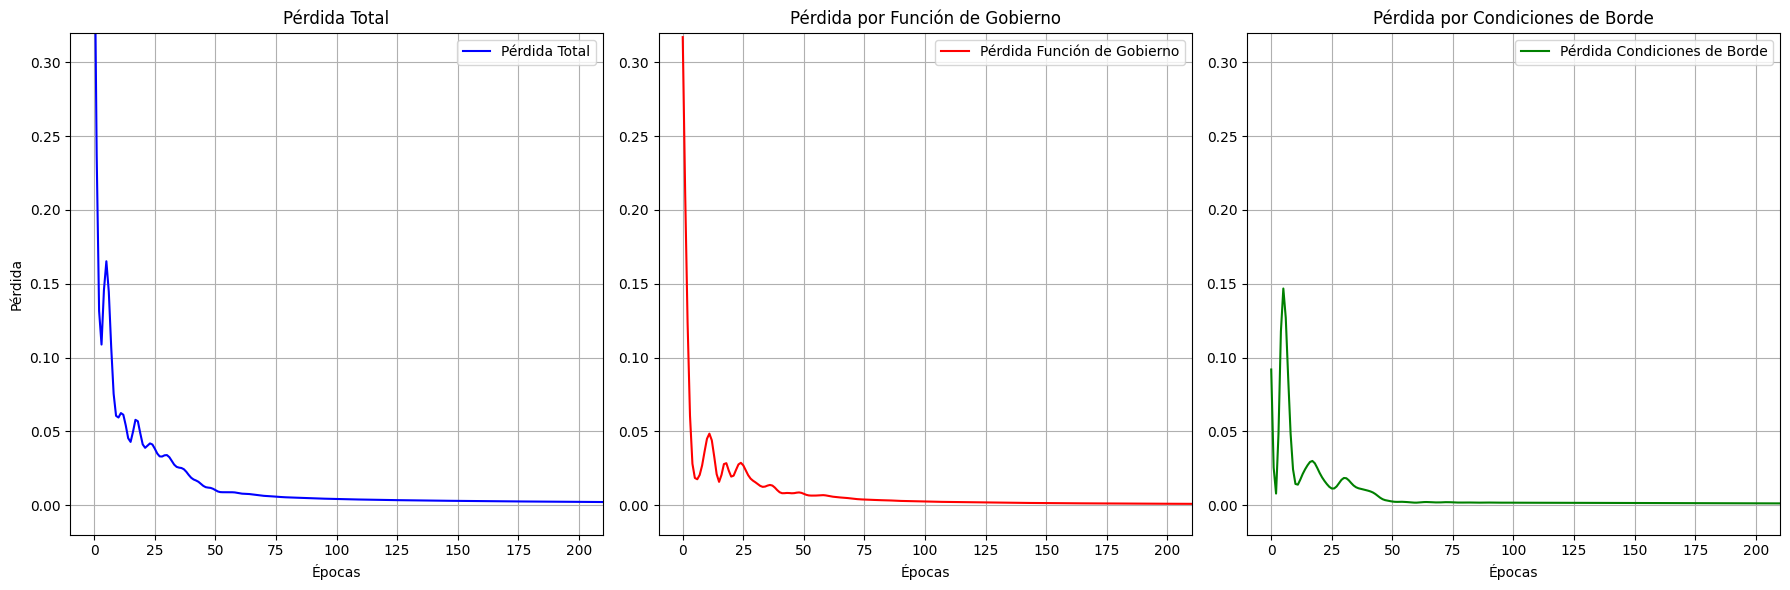

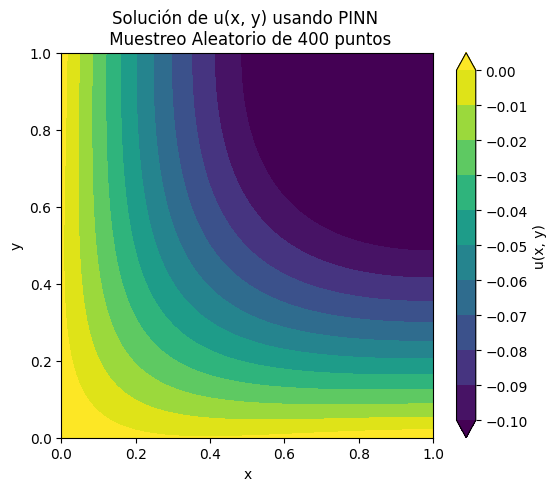

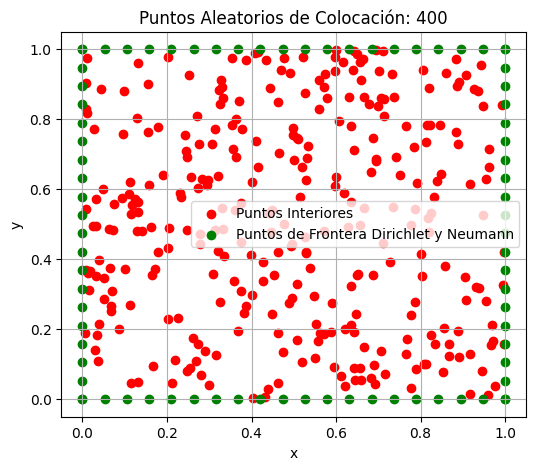

In [8]:
# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)

# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio
num_samples = 400  # Total de puntos
num_boundary_samples = int(0.20 * num_samples)  # 20% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 80% para el interior

# Crear puntos interiores
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 100 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo en una grilla densa (1000x1000)
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(1000, 1000)

# Graficar la solución interpolada
plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Muestreo Aleatorio de 400 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(6, 5))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera Dirichlet y Neumann')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

# Configuraciones del gráfico
plt.title("Puntos Aleatorios de Colocación: 400")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### II - Cantidad de puntos de colocación de Halton equivalente a grilla de 20x20 (400 puntos).

Época 0, Pérdida total: 0.3655591607093811
Época 100, Pérdida total: 0.0038507338613271713
Época 200, Pérdida total: 0.0025421567261219025
Época 300, Pérdida total: 0.0017532460624352098
Época 400, Pérdida total: 0.0012117652222514153
Época 500, Pérdida total: 0.0007485980167984962
Época 600, Pérdida total: 0.0006995180738158524
Época 700, Pérdida total: 0.0005819763173349202
Época 800, Pérdida total: 0.0005456898943521082
Época 900, Pérdida total: 0.0005156388506293297
Época 1000, Pérdida total: 0.0009695516200736165
Época 1100, Pérdida total: 0.0004843815113417804
Época 1200, Pérdida total: 0.00046640020445920527
Época 1300, Pérdida total: 0.0004523887182585895
Época 1400, Pérdida total: 0.0004408938402775675
Época 1500, Pérdida total: 0.00043087598169222474
Época 1600, Pérdida total: 0.00045564823085442185
Época 1700, Pérdida total: 0.00041971218888647854
Época 1800, Pérdida total: 0.00041025393875315785
Época 1900, Pérdida total: 0.00040149420965462923


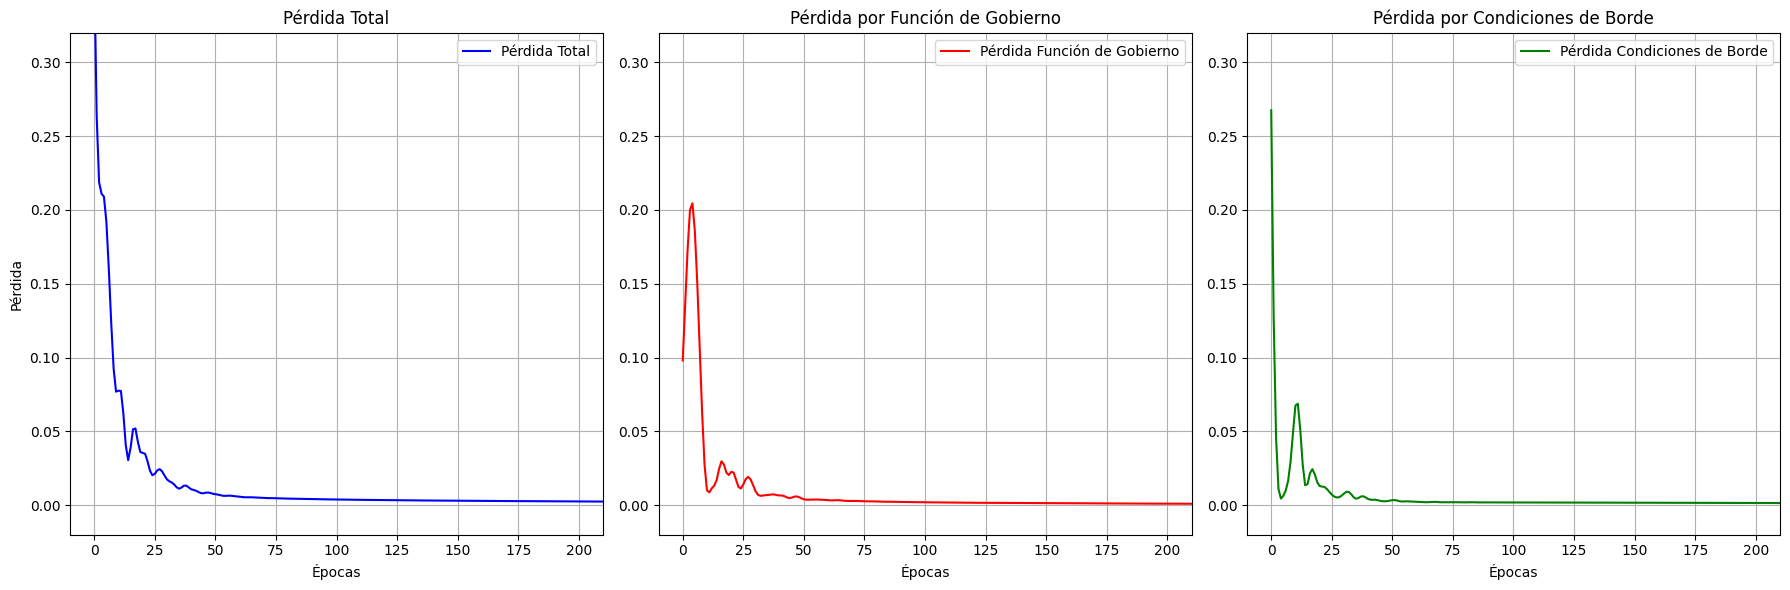

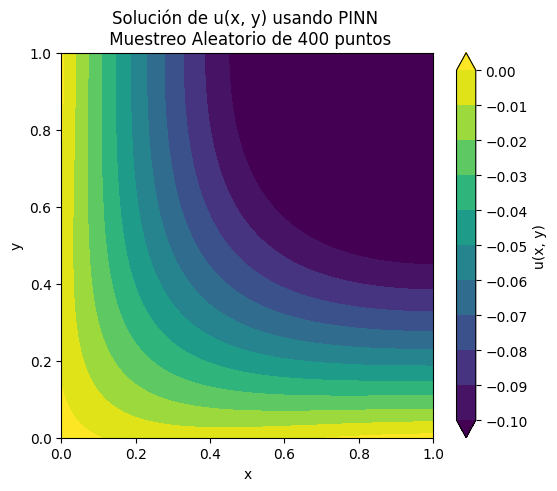

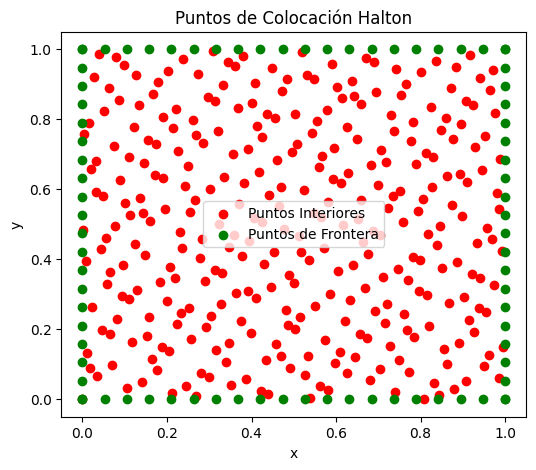

In [9]:
# Función para generar la secuencia Halton para una dimensión dada
def halton_sequence(index, base):
    result = 0.0
    f = 1.0 / base
    while index > 0:
        result += f * (index % base)
        index //= base
        f /= base
    return result

# Función para generar secuencias Halton en múltiples dimensiones
def generate_halton_samples(num_samples, dimensions, bases=None):
    if bases is None:
        bases = [2, 3]  # Base predeterminada para cada dimensión (puedes ajustarlas)

    samples = []
    for i in range(num_samples):
        sample = [halton_sequence(i, bases[d]) for d in range(dimensions)]
        samples.append(sample)
    return np.array(samples)

# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)

# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio usando secuencia Halton
num_samples = 400  # Total de puntos
num_boundary_samples = int(0.20 * num_samples)  # 20% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 80% para el interior

# Generar puntos Halton para los puntos interiores (con 2 dimensiones)
halton_samples = generate_halton_samples(num_interior_samples, 2)

# Convertir los puntos Halton a tensor de PyTorch
xy_interior_random = torch.tensor(halton_samples, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras (sin cambios)
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 100 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo en una grilla densa (1000x1000)
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(1000, 1000)

# Graficar la solución interpolada
plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Muestreo Aleatorio de 400 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(6, 5))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

plt.legend()
plt.title("Puntos de Colocación Halton")
plt.xlabel("x")
plt.ylabel("y")
plt.show()